In [1]:
import os
os.chdir('/g/data/vf71/la6889/dbpm_southern_ocean/scripts/')
from glob import glob
import xarray as xr
import json
import pandas as pd
import numpy as np
import useful_functions as uf
from dask.distributed import Client

In [25]:
ccamlr_effort = pd.read_parquet('../data/input_ccamlr_effort_gridded.parquet')

In [58]:
base_folder = '/g/data/vf71/la6889/dbpm_inputs/weddell/'
model_res = '1deg'
reg_int = 'fao-48'
out_folder = os.path.join(base_folder, 'gridded_params', model_res)
os.makedirs(out_folder, exist_ok = True)

In [59]:
depth = xr.open_zarr(glob(
    os.path.join(base_folder, 'gridded', model_res, 
                 f'gfdl-mom6-cobalt2_obsclim_deptho_*_{reg_int}_fixed.zarr/'))[0])['deptho']

#Loading intercept data for model period and fixing time values
int_phy_zoo  = xr.open_zarr(glob(
    os.path.join(base_folder, 'gridded', model_res,
                 f'gfdl-mom6-cobalt2_obsclim_intercept_*_{reg_int}_monthly_1961_2010.zarr/'))[0])['intercept']

In [60]:
new_eff = ccamlr_effort[ccamlr_effort.region == reg_int.replace('-', ' ').upper()]

In [61]:
ccamlr_eff = (xr.DataArray(new_eff['eff_rel_area'],
             dims = 'time',
             coords = {'time': int_phy_zoo.time.sel(time = new_eff.time.values)}).
    expand_dims({'lat': depth.lat, 'lon': depth.lon}).
                 transpose('time', 'lat', 'lon')).where(np.isfinite(depth))
ccamlr_eff.name = 'effort'

In [62]:
yr = '1969'
eff_ds = (xr.open_mfdataset(
    glob(os.path.join(base_folder, 'run_fishing', model_res, f'effort*{yr}*'))).
    sel(time = f'{yr}-12'))['effort']

In [63]:
ccamlr_eff = xr.concat([eff_ds, ccamlr_eff], dim = 'time')
ccamlr_eff = ccamlr_eff.chunk({'time': -1, 'lat': -1, 'lon': -1})
ccamlr_eff

<xarray.DataArray 'effort' (time: 493, lat: 33, lon: 112)> Size: 15MB
dask.array<rechunk-merge, shape=(493, 33, 112), dtype=float64, chunksize=(493, 33, 112), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 264B -50.5 -51.5 -52.5 -53.5 ... -80.5 -81.5 -82.5
  * lon      (lon) float64 896B -81.5 -80.5 -79.5 -78.5 ... 26.5 27.5 28.5 29.5
  * time     (time) datetime64[ns] 4kB 1969-12-01 1970-01-01 ... 2010-12-01

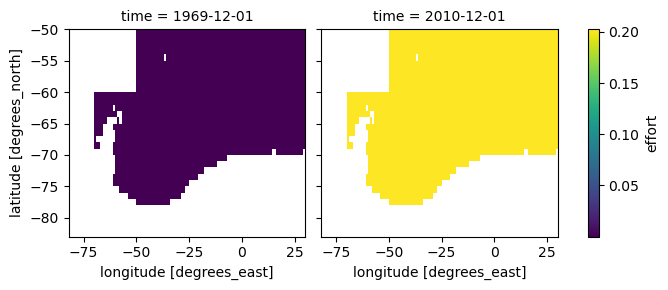

In [64]:
ccamlr_eff.isel(time = [0, -1]).plot(col = 'time')

In [65]:
ccamlr_eff.to_zarr(
    os.path.join(out_folder, f'new_eff_{model_res}_{reg_int}_monthly_1961_2010.zarr/'),
                   consolidated = True, mode = 'w')

In [22]:
init_ds = (xr.open_mfdataset(
    glob(os.path.join(base_folder, 'run_fishing', model_res, f'[p|d]*s_*{yr}*'))).
    sel(time = f'{yr}-11'))

In [24]:
init_ds.detritus.to_netcdf(
    os.path.join(base_folder, 'run_fishing', model_res,
                 f'detritus_{model_res}_{reg_int}_{yr}-11.nc'))
init_ds.detritivores.to_netcdf(
    os.path.join(base_folder, 'run_fishing', model_res,
                 f'detritivores_{model_res}_{reg_int}_{yr}-11.nc'))
init_ds.predators.to_netcdf(
    os.path.join(base_folder, 'run_fishing', model_res,
                 f'predators_{model_res}_{reg_int}_{yr}-11.nc'))